### DATA620 - Final Project
#### Michael Ippolito
7/7/2022

### Project Overview



### Link to video presentation

[Video](https://github.com/mmippolito/cuny_data620_final_project/blob/main/ippolito_video.mp4?raw=true)

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import csv
import os
import requests
import numpy as np
from scipy import stats
import pandas as pd
from collections import Counter
import plotly.express as px
import plotly.io as pio
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.metrics import ConfusionMatrix, precision, recall
import nltk
import random
import math
import collections
import json
import time

# Set module options
pio.renderers.default = 'jupyterlab'       # Set ploty renderer so graphs show up in HTML output
pd.set_option('display.width', 160)        # Set pandas display options
pd.set_option('display.max_colwidth', 80)  # Set max width of each column


#### Google Fact Check Tools json structures

Querying against Google Fact Check Tools will generate a "claim" json structure like this:
```
    {
      "text": string,
      "claimant": string,
      "claimDate": string,
      "claimReview": [
        {
          object (ClaimReview)
        }
      ]
    }
```
The "claimReview" element is itself a json with the following structure:
```
    {
      "publisher": {
        object (Publisher)
      },
      "url": string,
      "title": string,
      "reviewDate": string,
      "textualRating": string,
      "languageCode": string
    }
```
Within the claimReview json is another json, the "publisher," with this structure:
```
    {
      "name": string,
      "site": string
    }
```

#### Querying the data using the Google Fact Check API

We'll use an API token that I generated previously to run the queries. I limited my searches to the query topics listed below. To be polite, I stored the results the first time I ran this, then on subsequent runs I loaded the results from disk.


In [9]:
# Set parameters
queryAPI = False    # query the API (set to False to load from disk instead)
pageSize = '50'    # how many documents to retrieve at once

# Queries to run (each one must be run individually, as the API doesn't support boolean "or")
queries = ['gun', 'guns', 'gun violence', 'second amendment', '2nd amendment', 'firearm', 'firearms' 'shooting', 'shootings']

# Only do this if we've chosen to read from the API as opposed to disk
if queryAPI == False:

    # Read from disk instead of querying API
    print('Not querying API, reading from disk instead')
    
else:

    # Read API key from disk (in .gitignore to prevent from being published)
    fh = open('.apikey', 'r')
    apiKey = fh.read()
    fh.close()

    # Figure out where were left off so that we can come back to the queries later without starting at the beginning
    query_index = 0
    offset = 0

    # Read the topic and offset from disk; values will be a comma-separate pair of integers
    fhoffset = open('offset.txt', 'r')
    try:
        query_index = int(fhoffset.read())
        print('Starting from topic "' + queries[query_index] + '"')
    except Exception as ex:
        print('Error while retrieving query_index from offset.txt, using query_index of 0 instead:', ex)
    fhoffset.close()
    print()

    # Store results in claims.txt
    fhout = open('claims.txt', 'a')
    
    # Iterate through each query, storing the results on disk
    totalClaims = 0
    for i, query in enumerate(queries):
        
        # Skip queries we've already run before
        if i < query_index:
            continue

        # Set the base url; we'll need to append the pageToken to it for queries that contain more results than [pageSize]
        urlBase = 'https://factchecktools.googleapis.com/v1alpha1/claims:search?key={}&pageSize={}&query={}'.format(apiKey, pageSize, query)
        url = urlBase
        hdrs = {'Accept': 'application/json'}

        # Keep querying until there are no more claims to download
        numClaims = 0
        while True:
            print('Downloading next set of claims from', url.replace(apiKey, '[redacted]'))
            
            # Send the REST request
            r = requests.get(url, headers=hdrs)
            
            # Make sure we get a valid status code back; otherwise break
            if r.status_code != 200:
                print('Err: requests returned status code', r.status_code, ':', r.text)
                
                # Check for 500-level errors; this could mean we've queries too fast; set a backoff timeout
                if str(r.status_code)[0] == '5':
                    print('Sleepig for 5 seconds before trying again')
                    time.sleep(5)
                    continue
                
            # Load the results as a json structure
            j = json.loads(r.text)
            
            # Make sure there is a 'claims' key in the results and that there are more than zero results; otherwise break
            if 'claims' not in j.keys():
                break
            if len(j['claims']) == 0:
                break

            # Add the query topic to each claim
            for e in j['claims']:
                e['topic'] = query
            
            # Update the counter
            numClaims += len(j['claims'])
            totalClaims += len(j['claims'])
            print('Downloaded', numClaims, 'claims')
            
            # Write the results to claims.txt
            fhout.write(json.dumps(j['claims']) + '\n')
            
            # If there isn't a nextPageToken in the results, that means there are no more results for this query, and we can break from the loop
            if 'nextPageToken' not in j.keys():
                break
                
            # If nextPageToken is set, that means there are more claims for this query and we should keep going
            pageToken = j['nextPageToken']
            url = urlBase + '&pageToken=' + pageToken
            #if numClaims > 100: break   # temp/testing

        # Update the offset file with the topic index so we can come back to this later without starting over from the beginning
        fhoffset = open('offset.txt', 'w')
        fhoffset.write(str(i + 1))
        fhoffset.close()

    # Cleanup
    fhout.close()
    print()
    print('Downloaded', totalClaims, 'claims total')
    print()

# Read claims from disk
claims = []
print('Reading claims from disk')
print()
fh = open('claims.txt')

# Iterate through each line, storing as an array of dicts
i = 0
while True:
    l = fh.readline()
    if not l:
        break
    l = l.strip()       # remove whitespace
    j = json.loads(l)   # each line will contain a list of dicts in json format
    claims += j         # append this list to the claims list

# Cleanup
fh.close()
print('Read', len(claims), 'from disk')
print()


Not querying API, reading from disk instead
Reading claims from disk

Read 1566 from disk



#### Load the results into a dataframe

After reading from disk, load the results into a dataframe. The "claimReview" column contained a json structure that I had to split into separate columns.


In [12]:
# Convert list to data frame
df1 = pd.DataFrame(claims)

# Convert dict structure of claimReview column to individual columns
for i, row in df1.iterrows():
    
    # claimRevew column contains a dict; need to split this out into individual columns
    crdict = list(row['claimReview'])[0]    # claim reviews only have a single element
    publisher_name = ''
    publisher_site = ''
    url = ''
    title = ''
    reviewDate = ''
    textualRating = ''
    languageCode = ''
    if 'publisher' in crdict.keys():
        if 'name' in crdict['publisher'].keys(): publisher_name = crdict['publisher']['name']
        if 'site' in crdict['publisher'].keys(): publisher_site = crdict['publisher']['site']
    if 'url' in crdict.keys(): url = crdict['url']
    if 'title' in crdict.keys(): title = crdict['title']
    if 'reviewDate' in crdict.keys(): reviewDate = crdict['reviewDate']
    if 'textualRating' in crdict.keys(): textualRating = crdict['textualRating']
    if 'languageCode' in crdict.keys(): languageCode = crdict['languageCode']
    df1.loc[i, 'publisher_name'] = publisher_name
    df1.loc[i, 'publisher_site'] = publisher_site
    df1.loc[i, 'url'] = url
    df1.loc[i, 'title'] = title
    df1.loc[i, 'reviewDate'] = reviewDate
    df1.loc[i, 'textualRating'] = textualRating
    df1.loc[i, 'languageCode'] = languageCode

# Drop the original claimReview column that contains the dict structure
df1.drop(columns=['claimReview'], inplace=True)
display(df1)


,text,claimant,claimDate,topic,publisher_name,publisher_site,url,title,reviewDate,textualRating,languageCode
0,Video shows Lindsey Graham being heckled after he announced his support for ...,Social media users,2022-06-22T00:00:00Z,gun,USA Today,usatoday.com,https://www.usatoday.com/story/news/factcheck/2022/07/05/fact-check-2021-vid...,Fact check: 2021 video of Sen. Lindsey Graham resurfaces,2022-07-05T23:12:46Z,False,en
1,"The House voted to criminalize disassembling, cleaning and reassembling gun",Social media,2022-06-09T00:00:00Z,gun,USA Today,usatoday.com,https://www.usatoday.com/story/news/factcheck/2022/06/24/fact-check-false-cl...,Fact check: False claim that House bill outlaws disassembling and ...,2022-06-24T21:41:36Z,False,en
2,Handguns are illegal in Chicago,Social media,2022-05-30T00:00:00Z,gun,USA Today,usatoday.com,https://www.usatoday.com/story/news/factcheck/2022/06/23/fact-check-handguns...,Fact check: Handguns are legal in Chicago,2022-06-23T22:05:37Z,False,en
3,Video shows Muslims shooting guns during Kanpur violence,Multiple sources,2022-06-15T00:00:00Z,gun,AFP Fact Check,factcheck.afp.com,https://factcheck.afp.com/doc.afp.com.32CJ38U,Old video of dispute in India mispresented as 'jihadis' protesting over rema...,2022-06-16T09:45:00Z,False,en
4,Video shows woman pulling out a gun to shoot gunman in the US?,Multiple sources,2022-06-08T00:00:00Z,gun,AFP Fact Check,factcheck.afp.com,https://factcheck.afp.com/doc.afp.com.32CG642,"Video of woman shooting gunman filmed in Brazil in 2018, not United States",2022-06-16T12:12:00Z,False,en
...,...,...,...,...,...,...,...,...,...,...,...
1561,"Some mass shooters ""have been on Ritalin since they were in kindergarten.""",Oliver North,2018-05-20T00:00:00Z,shootings,The New York Times,nytimes.com,https://www.nytimes.com/2018/05/21/us/nra-oliver-north.html,Oliver North Blames 'Culture of Violence' for Mass Shootings ...,2018-05-21T00:00:00Z,Unproven.,en
1562,Video claimed to be of Indian army shooting at Kashmiris,Social media,2016-06-20T00:00:00Z,shootings,Alt News,altnews.in,https://www.altnews.in/video-of-police-drill-in-jharkhand-circulates-as-arme...,Video of police drill in Jharkhand circulates as armed forces shooting down ...,2018-10-29T00:00:00Z,False,en
1563,"In 2016, Dallas, Texas, has fewer ""police officer-related shootings than any...",Mike Rawlings,2016-07-08T00:00:00Z,shootings,PolitiFact,politifact.com,http://www.politifact.com/factchecks/2016/jul/12/mike-rawlings/does-dallas-h...,Does Dallas have fewest police shootings in America? Impossible to tell,2016-07-12T19:08:42Z,Half True,en
1564,"“Black men, unarmed, black teenagers, unarmed, and black children, unarmed, ...",Beto O'Rourke,2018-08-21T00:00:00Z,shootings,The Washington Post,washingtonpost.com,https://www.washingtonpost.com/politics/2018/08/30/beto-orourkes-claims-blac...,Analysis | Beto O'Rourke's claims on African Americans and police ...,2018-08-30T10:45:11Z,Not the Whole Story,en


#### Normalizing the textualRating column

The textualRating column is a free-form field which we'll need to try and classify if we want to use it.


In [48]:
# First, group and sort by textualRating, then display the dataframe
dfrating = df1.groupby(['textualRating'], as_index=False).size()
dfrating.sort_values(['size'], ascending=False, inplace=True)
pd.set_option('display.max_rows', 100)
display(dfrating)
pd.set_option('display.max_rows', 60)


,textualRating,size
35,False,548
77,Mostly False,100
79,Mostly True,92
102,Pants on Fire,82
135,True,78
...,...,...
48,Got the wrong person,1
45,Flip- flop,1
88,No Such Case,1
43,Fałsz,1


#### Key to the rating categories

Because of the wide range of textual ratings, I developed a key to normalize each rating into numerical format, as follows.


In [49]:
# Display the rating key
dfratingkey = pd.read_csv('dfratingkey.csv')
display(dfratingkey)


,newRating,ratingText
0,0,can't tell
1,1,false
2,2,mostly false
3,3,half true
4,4,mostly true
5,5,true but misleading
6,6,true


#### Convert ratings to numerical form

We'll need to convert each rating to its numerical form. I hand-classified each one and stored it in dfrating.csv. This shows a sample of the new categories I manually classified.


In [50]:
# Open the file where the hand-classified ratings are stored
dfnewrating = pd.read_csv('dfrating.csv', encoding='ISO-8859-1')
display(dfnewrating)


,textualRating,newRating
0,FALSE,1
1,Mostly False,2
2,Mostly True,2
3,TRUE,6
4,Pants on Fire,1
...,...,...
164,Got the wrong person,1
165,Flip- flop,0
166,No Such Case,1
167,Fa?sz,1


#### Merge ratings with the main dataframes

Then we'll merge the new rating with the main dataframe so that the new rating number is included in the data.


In [51]:
# Merge the new ratings with the main dataframe
df2 = pd.merge(df1, dfnewrating, on=['textualRating'], how='inner')
display(df2)


,text,claimant,claimDate,topic,publisher_name,publisher_site,url,title,reviewDate,textualRating,languageCode,newRating
0,Murders make up only 17% of gun-related deaths in the United States.,facebook.com,2022-06-07T00:10:00Z,gun,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2022/06/fact-check-murders-are-not-only-1...,Fact Check: Murders Are NOT Only 17% Of Gun-Related Deaths In US; The Number...,2022-06-07T00:10:00Z,43% Murders,en,5
1,Murders make up only 17% of gun-related deaths in the United States.,facebook.com,2022-06-07T00:10:00Z,gun violence,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2022/06/fact-check-murders-are-not-only-1...,Fact Check: Murders Are NOT Only 17% Of Gun-Related Deaths In ...,2022-06-07T00:10:00Z,43% Murders,en,5
2,"Says U.S. Sen. Ron Johnson, his prospective opponent, has received $1.2 mill...",Mandela Barnes,2022-05-27T00:00:00Z,gun,PolitiFact,politifact.com,https://www.politifact.com/factchecks/2022/jun/28/mandela-barnes/barnes-part...,Barnes partially right on claim that Johnson has received $1.2 ...,,Half True,en,3
3,"In 2013, under a Democratic Senate, ""a majority of the Senate voted in favor...",Ted Cruz,2022-05-26T00:00:00Z,gun,PolitiFact,politifact.com,https://www.politifact.com/factchecks/2022/may/27/ted-cruz/ted-cruz-spins-pa...,Ted Cruz spins partisan blame for failure of gun legislation,,Half True,en,3
4,"The ""boyfriend loophole"" means that ""if you commit a serious crime of domest...",Amy Klobuchar,2019-08-12T00:00:00Z,gun,PolitiFact,politifact.com,https://www.politifact.com/factchecks/2019/aug/22/amy-klobuchar/boyfriend-lo...,Federal law's 'boyfriend loophole' is not so simple,,Half True,en,3
...,...,...,...,...,...,...,...,...,...,...,...,...
915,"« Les flash-balls sont équipés de viseurs holographiques, ce qui permet des ...",Facebook,2019-01-03T00:00:00Z,shootings,20 Minutes,20minutes.fr,https://www.20minutes.fr/societe/2406987-20190103-manifestations-lanceurs-ba...,Manifestations: Les lanceurs de balles de défense utilisés par les forces de...,2019-01-03T00:00:00Z,rather_false,fr,2
916,"""Las Vegas Shooter Reportedly a Democrat Who Liked Rachel Maddow, MoveOn.org...",Bloggers,2017-10-02T00:00:00Z,shootings,PolitiFact,politifact.com,http://www.politifact.com/article/2017/oct/02/hoaxes-fake-news-about-las-veg...,"Hoaxes, fake news about the Las Vegas massacre",2017-10-02T16:36:56Z,Got the wrong person,en,1
917,"Kate Steinle's shooter's immigration and criminal history ""not used in court""",Donald Trump,2017-12-01T00:00:00Z,shootings,PolitiFact,politifact.com,http://www.politifact.com/article/2017/dec/18/Donald-Trumps-misleading-claim...,"Donald Trump's misleading claims in the Kate Steinle case, fact-checked",2017-12-18T16:17:57Z,It's Calif. law,en,0
918,"Las Vegas shooter, Stephen Paddock, acted on behalf of ISIS.",ISIS,2017-10-02T00:00:00Z,shootings,CBS News,cbsnews.com,https://www.cbsnews.com/news/las-vegas-shooting-isis-terror-group-transforma...,Las Vegas shooting claim from ISIS shows terror group's transformation as it...,2017-10-06T00:00:00Z,No proof of ISIS links (FBI),en,1


#### Explore ratings categories

Then we'll group and sort the dataframe by the new ratings to explore how many of each rating there are.

,newRating,size,ratingText
5,6,26,true
2,5,167,true but misleading
6,4,4,mostly true
4,3,84,half true
1,2,232,mostly false
0,1,285,false
3,0,122,can't tell


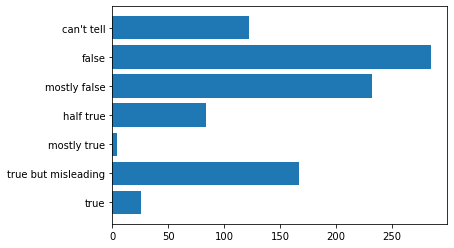

In [52]:
# Group and sort the new rating dataframe
dfnewrating = df2.groupby(['newRating'], as_index=False).size()
dfnewrating.sort_values(['size'], ascending=False, inplace=True)

# Merge the rating key to the grouped data frame so we can see not only the rating number but the label I gave it
dfnewrating = pd.merge(dfnewrating, dfratingkey, on=['newRating'], how='inner')
dfnewrating.sort_values(['newRating'], ascending=False, inplace=True)
display(dfnewrating)

# Plot the rating counts
plt.barh(y=dfnewrating['ratingText'], width=dfnewrating['size'])
plt.show()

#### Explore claimants

Now let's look at the claimants to see if they need normalization.


In [65]:
# Group by claimant
dfclaimants = df2.groupby(['claimant'], as_index=False).size()
dfclaimants.sort_values(['size'], ascending=False, inplace=True)
display(dfclaimants)


,claimant,size
42,Donald Trump,54
81,Joe Biden,41
135,SOCIAL MEDIA POST,23
174,Viral image,23
14,Barack Obama,21
...,...,...
55,Facebook users,1
51,Facebook page of “Azamgarh Express”,1
50,Facebook account,1
168,Utilizador de Facebook,1


#### Normalize claimants

Since there are 199 unique claimants, normalize this as much as possible by hand-classifying and storing the new values in csv. Here we'll load the csv and join it to the original dataframe.


In [74]:
# Load the csv with the lookup values for the new claimant.
dfclaimants = pd.read_csv('dfclaimants.csv', encoding='utf-8')
display(dfclaimants)


,claimant,claimantNorm,claimantCat
0,Adam Best,Adam Best,entertainer
1,Akun Facebook,Facebook user(s),social media user(s)
2,Alcee Hastings,Alcee Hastings,politician
3,Alec Baldwin,Alec Baldwin,entertainer
4,Alyssa Milano,Alyssa Milano,entertainer
...,...,...,...
194,Wayne LaPierre,Wayne LaPierre,"political website, show, or commentator"
195,Wayne Messam,Wayne Messam,politician
196,"Wilder Morais (PP-GO), senador",Wilder Morais,politician
197,YourNewsWire,yournewswire.com,"political website, show, or commentator"


#### Merge the normalized claimant

Now merge the normalized claimant with the original data frame.


In [75]:
# Merge the normalized claimant back to the original dataframe
df3 = pd.merge(df2, dfclaimants, on=['claimant'], how='inner')
display(df3)


,text,claimant,claimDate,topic,publisher_name,publisher_site,url,title,reviewDate,textualRating,languageCode,newRating,claimantNorm,claimantCat
0,Murders make up only 17% of gun-related deaths in the United States.,facebook.com,2022-06-07T00:10:00Z,gun,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2022/06/fact-check-murders-are-not-only-1...,Fact Check: Murders Are NOT Only 17% Of Gun-Related Deaths In US; The Number...,2022-06-07T00:10:00Z,43% Murders,en,5,Facebook user(s),social media user(s)
1,Murders make up only 17% of gun-related deaths in the United States.,facebook.com,2022-06-07T00:10:00Z,gun violence,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2022/06/fact-check-murders-are-not-only-1...,Fact Check: Murders Are NOT Only 17% Of Gun-Related Deaths In ...,2022-06-07T00:10:00Z,43% Murders,en,5,Facebook user(s),social media user(s)
2,Accused Kenosha shooter Kyle Rittenhouse was required to be at his initial e...,facebook.com,2020-09-22T19:00:07Z,shootings,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2020/09/fact-check-kyle-rittenhouse-did-n...,Fact Check: Accused Kenosha Shooter Kyle Rittenhouse Did NOT Have To Be At I...,2020-09-22T19:00:07Z,Missing Context,en,5,Facebook user(s),social media user(s)
3,Photo of Person Wearing a Checkered Skirt Is the Texas School Shooter,facebook.com,2022-05-27T20:33:00Z,shootings,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2022/05/fact-check-no-evidence-photo-of-p...,Fact Check: NO Evidence Photo Of Person Wearing Checkered Skirt Is Texas Sch...,2022-05-27T20:33:00Z,Unsupported,en,0,Facebook user(s),social media user(s)
4,Statistics about gun deaths in various countries are from last year.,facebook.com,2020-11-19T01:26:00Z,gun,Lead Stories,leadstories.com,https://leadstories.com/hoax-alert/2020/11/fact-check-the-statistics-on-this...,Fact Check: The Statistics On This Protest Sign Are NOT From 'Last Year' -- ...,2020-11-19T01:26:00Z,Very Old Stats,en,5,Facebook user(s),social media user(s)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,"“Including today’s shooting incident at a Texas high school, this year there...",CNN,2018-05-18T00:00:00Z,shootings,PolitiFact,politifact.com,http://www.politifact.com/article/2018/may/18/whats-true-whats-not-about-san...,"What's true, what's not about Santa Fe, Texas, school shooting",2018-05-18T19:46:24Z,By Some Counts Yes,en,5,CNN,mainstream journalist or news outlet
852,"“Including today’s shooting incident at a Texas high school, this year there...",CNN,2018-05-18T00:00:00Z,shootings,PolitiFact,politifact.com,http://www.politifact.com/article/2018/may/18/whats-true-whats-not-about-san...,"What's true, what's not about Santa Fe, Texas, school shooting",2018-05-18T19:46:24Z,By Some Counts Yes,en,5,CNN,mainstream journalist or news outlet
853,"“Including today’s shooting incident at a Texas high school, this year there...",CNN,2018-05-18T00:00:00Z,shootings,PolitiFact,politifact.com,http://www.politifact.com/article/2018/may/18/whats-true-whats-not-about-san...,"What's true, what's not about Santa Fe, Texas, school shooting",2018-05-18T19:46:24Z,By Some Counts Yes,en,5,CNN,mainstream journalist or news outlet
854,"Las Vegas shooter, Stephen Paddock, acted on behalf of ISIS.",ISIS,2017-10-02T00:00:00Z,shootings,CBS News,cbsnews.com,https://www.cbsnews.com/news/las-vegas-shooting-isis-terror-group-transforma...,Las Vegas shooting claim from ISIS shows terror group's transformation as it...,2017-10-06T00:00:00Z,No proof of ISIS links (FBI),en,1,ISIS,government entity


#### Explore claimant counts

Now look at claimant counts again after normalizing.


In [76]:
# Group by claimant
dfclaimant2 = df3.groupby(['claimantNorm'], as_index=False).size()
dfclaimant2.sort_values(['size'], ascending=False, inplace=True)
display(dfclaimant2)

# Group by claimant category
dfclaimant3 = df3.groupby(['claimantCat'], as_index=False).size()
dfclaimant3.sort_values(['size'], ascending=False, inplace=True)
display(dfclaimant3)


,claimantNorm,size
132,social media user(s),118
41,Facebook user(s),61
35,Donald Trump,57
135,various sources,41
64,Joe Biden,41
...,...,...
13,Bernie Sanders,1
91,Newsweek,1
92,Oliver North,1
101,Ram Gopal Varma,1


,claimantCat,size
6,politician,409
8,social media user(s),239
5,"political website, show, or commentator",58
1,entertainer,44
9,various sources,41
3,gun association,35
4,mainstream journalist or news outlet,19
0,PAC,5
2,government entity,5
7,private industry,1
